<a href="https://colab.research.google.com/github/micah-shull/LLMs/blob/main/LLM_027_format_data_for_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Prepare Data for LLM Fine-Tuning

In this notebook, we’ll walk through the process of **preparing the MTSamples dataset** for fine-tuning a large language model (LLM) on specialized medical data. Our aim is to transform the dataset into a structured, model-ready format that will enhance an LLM’s ability to understand and generate precise medical content. This data preparation process is crucial for improving model performance in a highly specialized domain, where nuances in language and terminology are essential.

Large language models demonstrate impressive capabilities across general domains; however, when it comes to highly specialized fields like medicine, several challenges can impact their performance. These challenges underscore the importance of well-structured, domain-specific data:

1. **Training Data Limitations**:  
   LLMs are trained on massive, diverse datasets sourced from the internet. However, due to privacy regulations like HIPAA, the availability of high-quality medical content online is limited. As a result, these models may not have extensive exposure to specialized medical knowledge, making domain-specific fine-tuning valuable.

2. **Complexity and Specificity in Medical Data**:  
   Medical data contains specialized terminology, complex concepts, and highly specific relationships. Effective performance in this domain requires more than basic language comprehension; it demands an understanding of context, terminology, and medical nuances that general LLMs may oversimplify.

3. **Generalization vs. Specialization**:  
   LLMs are designed to be generalists, handling a wide array of topics. While they can process basic medical queries, they often lack the depth and accuracy needed for precise medical content. Fine-tuning with carefully prepared data helps bridge this gap, allowing the model to adapt to the unique demands of medical language.

### Objectives

To ensure effective preparation for fine-tuning, we will work through the following steps:

- **Dataset Exploration**:  
  We’ll begin by examining the MTSamples dataset to understand its structure and content.
  
- **Data Preprocessing**:  
  Preparing the data involves more than simply formatting it for input. We’ll transform the dataset to meet the specific input requirements for an LLM, including tokenization, adding role-based prompts, handling class imbalance, and organizing labels.

- **Formatting for LLM Fine-Tuning**:  
  Structuring each sample according to LLM requirements, such as role-based prompts (e.g., system, user, assistant), enables the model to understand how to process medical reports effectively.

- **Applications & Use-Cases**:  
  The final prepared dataset will be suitable for fine-tuning a language model to interpret, classify, and generate medical content accurately—valuable for healthcare professionals, researchers, and students.

This preparation process will result in a robust, fine-tuning-ready dataset that enables the LLM to better understand and engage with specialized medical content. The dataset was originally obtained from [kaggle](https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/). Note that we already removed all unncessary columns. More information can be found here [MTSamples](https://mtsamples.com/) dataset.



### Import Data




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

medical_reports = pd.read_csv("/content/reports.csv")
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [ ]:
print(medical_reports['report'][0][0:120])
print(medical_reports['report'][1][0:120])
print(medical_reports['report'][2][0:120])
print('---'*30)
print(medical_reports["medical_specialty"].value_counts())


2-D M-MODE: , ,1.  Left atrial enlargement with left atrial diameter of 4.7 cm.,2.  Normal size right and left ventricle
1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ventricular systolic fu
2-D ECHOCARDIOGRAM,Multiple views of the heart and great vessels reveal normal intracardiac and great vessel relationshi
------------------------------------------------------------------------------------------
medical_specialty
Surgery                       1088
Cardiovascular / Pulmonary     371
Radiology                      273
Gastroenterology               224
Neurology                      223
Name: count, dtype: int64


### Imbalanced Data

---

### Interpreting the Imbalance for Fine-Tuning

An imbalanced dataset can affect fine-tuning because the model is exposed to certain classes far more than others. Here’s what it means for fine-tuning:

1. **Model Bias**:
   - The model may become biased towards predicting the more frequent classes (e.g., "Surgery" or "Cardiovascular / Pulmonary").
   - This happens because it “sees” these classes more often and may assume they’re more likely, which can harm its ability to generalize to underrepresented classes.

2. **Performance Metrics**:
   - **Precision, Recall, and F1-Score**: Imbalance may lead to high accuracy for the majority classes, but poor precision or recall for minority classes. F1-score for each class will give a better sense of how well the model performs across classes.
   - **Macro-Averaged Metrics**: For imbalanced data, using metrics like **macro-averaged F1-score** (which averages the F1-scores for each class equally) helps evaluate performance across all classes rather than being dominated by the majority class.

3. **Possible Solutions**:
   - **Resampling**: Techniques like **oversampling** the minority classes or **undersampling** the majority classes can help balance the dataset.
   - **Class-Specific Weights**: Setting **class weights** inversely proportional to the class frequency informs the model to pay more attention to minority classes, balancing the learning.
   - **Data Augmentation**: Creating more samples for underrepresented classes (e.g., using paraphrasing or back-translation) can also help.

Would you like to implement any of these strategies for handling the imbalance before we proceed to tokenization and fine-tuning? Let me know how you’d like to tackle this!

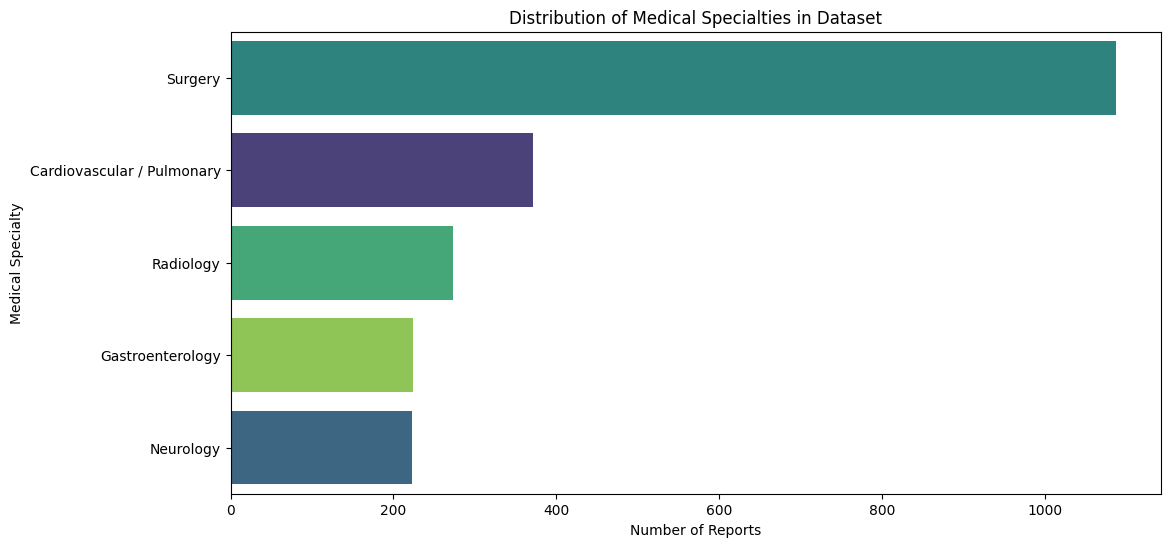

In [ ]:
# medical_reports.groupby("medical_specialty").count()

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure and size
plt.figure(figsize=(12, 6))

# Create the count plot for the 'medical_specialty' column
sns.countplot(data=medical_reports, y="medical_specialty", hue="medical_specialty", palette="viridis",
              order=medical_reports["medical_specialty"].value_counts().index)

# Add labels and title
plt.xlabel("Number of Reports")
plt.ylabel("Medical Specialty")
plt.title("Distribution of Medical Specialties in Dataset")
plt.show()


### Train-Test Split
To handle the class imbalance effectively while creating a train-test split, you want to ensure that each subset (train and test) maintains a similar class distribution to the original dataset. This process is called **stratified sampling** and helps the model generalize better by providing balanced exposure to each class during training and evaluation.

### Recommended Approach: Stratified Train-Test Split

Here’s how you can split the data while preserving the class distribution for each `medical_specialty`:

1. **`stratify`**: The `stratify` parameter in `train_test_split` allows us to maintain the class distribution in both `train_data` and `test_data`, which is crucial when dealing with imbalanced classes.
2. **Check Class Distribution**: After splitting, you can print the class distributions in both sets to ensure they mirror the original distribution closely.
3. **`test_size=0.2`**: Using 20% for testing is a typical choice, but you can adjust this depending on your needs and dataset size.

### Why Stratified Sampling Matters for Imbalanced Data

1. **Representative Testing Set**: Ensuring similar class distributions in the training and testing sets makes sure the model’s performance metrics on the test set are reflective of real-world performance across all classes.
2. **Improved Generalization**: With each class represented proportionally, the model can better generalize to minority classes, which might otherwise be underrepresented if split randomly.
3. **Avoiding Overfitting to Majority Classes**: Stratification helps avoid overfitting to the more frequent classes by exposing the model to a balanced view of the data during both training and testing.

### Additional Options

If you need further balance within the training set, you might consider:
- **Oversampling or Undersampling** on the `train_data` split only.
- **Class weights** in the model to emphasize the minority classes during training.


### Stratified Train Test Split

This approach indeed creates a **perfectly balanced dataset** by ensuring each class has an equal number of samples in the training, validation, and test sets. This can be a very effective strategy when you have enough data and want to ensure a balanced view across all classes. Let’s break down the pros and cons of this approach.

### Pros of This Approach

1. **Perfect Class Balance**:
   - Each class has the exact same number of samples in each subset, which avoids any risk of model bias toward the more frequent classes.
   - This setup is helpful if you want to compare model performance across classes without one class dominating the metrics.

2. **Clear Separation for Validation and Test**:
   - By separating `val` and `test` to have exactly 5 samples per class, you ensure consistency and can use each for different purposes (e.g., `val` for tuning and `test` for final evaluation).

3. **Simpler Analysis**:
   - Balanced classes simplify analysis and make it easier to interpret metrics like precision, recall, and F1-score across classes.

### Cons and Potential Considerations

1. **Loss of Data**:
   - By sampling a fixed number (110 per class) for the entire dataset, you’re discarding a significant portion of the available data, especially for classes with many more samples.
   - This reduction in data might limit the model’s performance since it isn’t using all available examples.

2. **May Not Reflect Real-World Distribution**:
   - A perfectly balanced dataset doesn’t always reflect real-world distributions, so the model might struggle in production scenarios where certain classes are more common than others.
   - If real-world deployment is your goal, training with an imbalanced dataset (with methods like class weighting) might help the model generalize better.




In [ ]:
from sklearn.model_selection import train_test_split

# Stratified split based on the 'medical_specialty' column
train_data, test_data = train_test_split(
    medical_reports,
    test_size=0.2,                 # 20% of the data for testing
    stratify=medical_reports["medical_specialty"],  # Preserve class distribution
    random_state=42                # Set a random seed for reproducibility
)

# Print class distribution in each split to verify
print("Class Distribution in Training Set:")
print(train_data["medical_specialty"].value_counts(normalize=True))

print("\nClass Distribution in Testing Set:")
print(test_data["medical_specialty"].value_counts(normalize=True))

Class Distribution in Training Set:
medical_specialty
Surgery                       0.499139
Cardiovascular / Pulmonary    0.170396
Radiology                     0.125072
Gastroenterology              0.102697
Neurology                     0.102697
Name: proportion, dtype: float64

Class Distribution in Testing Set:
medical_specialty
Surgery                       0.500000
Cardiovascular / Pulmonary    0.169725
Radiology                     0.126147
Gastroenterology              0.103211
Neurology                     0.100917
Name: proportion, dtype: float64


### Group By Train Test Split

In [ ]:
# Create a balanced dataset with equal samples per class
grouped_data = medical_reports.groupby("medical_specialty").sample(110, random_state=42)

# Further split into validation and test sets (5 samples per class for each)
val_test_data = grouped_data.groupby("medical_specialty").sample(10, random_state=42)
val = val_test_data.groupby("medical_specialty").head(5)
test = val_test_data.groupby("medical_specialty").tail(5)

# Use remaining data for training
train = grouped_data[~grouped_data.index.isin(val_test_data.index)]

# Check the distribution in each set
print("Training set class distribution:\n", train["medical_specialty"].value_counts())
print("\nValidation set class distribution:\n", val["medical_specialty"].value_counts())
print("\nTest set class distribution:\n", test["medical_specialty"].value_counts())

Training set class distribution:
 medical_specialty
Cardiovascular / Pulmonary    100
Gastroenterology              100
Neurology                     100
Radiology                     100
Surgery                       100
Name: count, dtype: int64

Validation set class distribution:
 medical_specialty
Cardiovascular / Pulmonary    5
Gastroenterology              5
Neurology                     5
Radiology                     5
Surgery                       5
Name: count, dtype: int64

Test set class distribution:
 medical_specialty
Cardiovascular / Pulmonary    5
Gastroenterology              5
Neurology                     5
Radiology                     5
Surgery                       5
Name: count, dtype: int64


### Token Counts

In [ ]:
# !pip install tiktoken

In [ ]:
# 3. Average, minimum, and maximum report length (in tokens, not words).
# This is important due to token limitations and also to estimate the price.
# Let's calculate the tokens for OpenAI's cheapest model, babbage-002
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string.
    (https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken)"""
    encoding = tiktoken.get_encoding("cl100k_base")  # encoding for currently all models
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [ ]:
report_lengths = train['report'].apply(lambda x: num_tokens_from_string(x))
avg_report_length = report_lengths.mean()
min_report_length = report_lengths.min()
max_report_length = report_lengths.max()
report_length_sum = report_lengths.sum()

print(f"Average report length: {avg_report_length:.2f} tokens")
print(f"Minimum report length: {min_report_length} tokens")
print(f"Maximum report length: {max_report_length} tokens")
print(f"# The training dataset consists of: {report_length_sum} tokens")


Average report length: 674.79 tokens
Minimum report length: 14 tokens
Maximum report length: 3701 tokens
# The training dataset consists of: 337394 tokens


In [ ]:
price_model = 0.0080   # Price for gpt-3.5-turbo per 1K tokens
model = "gpt-3.5-turbo"
price_per_epoch = (report_length_sum / 1000) * price_model
print(f"Fine-tuning of {model} costs ~ ${price_per_epoch:.2f} per epoch")

Fine-tuning of gpt-3.5-turbo costs ~ $2.70 per epoch


### Role of System, User, Assistant

Understanding the **roles of system, user, and assistant** in prompts is key to structuring effective interactions with language models, especially as we prepare data for tuning or fine-tuning. These roles guide the model’s behavior and help ensure it interprets each part of the conversation as intended.

We can rearrange the dataset into the necessary format in order to start the fine tuning job. The format is as follows:

```python
system_prompt = "Given the medical description report, classify it into one of these categories: " + \
                "[Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"

sample_prompt = {
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": train["report"].iloc[0]},
        {"role": "assistant", "content": train["medical_specialty"].iloc[0]}
    ]
}

```

---

### Key Roles in a Language Model Interaction

1. **System Role**:
   - **Purpose**: The system message sets the overarching **instructions and constraints** for the conversation. It defines the model’s role, establishes context, and specifies the task.
   - **Importance**: The system prompt frames the model’s behavior and focus, acting like a “guide” for the session. By specifying the categories here, you’re directing the model’s attention to specific topics, which is especially useful for fine-tuning the model to a task, like classifying medical reports.

   - **Example**:
     ```json
     {"role": "system", "content": "Given the medical description report, classify it into one of these categories: [Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"}
     ```

2. **User Role**:
   - **Purpose**: This message simulates the **input from the user** (often the task prompt or query). It asks the model to perform a specific action within the context set by the system.
   - **Importance**: Clearly structuring user inputs is crucial, as it enables the model to focus on the provided information or question and respond accurately. For fine-tuning, this role allows you to provide the model with various inputs that it needs to classify, ensuring the model learns to interpret diverse user inputs correctly.

   - **Example**:
     ```json
     {"role": "user", "content": "1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function are normal."}
     ```

3. **Assistant Role**:
   - **Purpose**: This role represents the model’s **response** to the user’s query or input. For classification tasks, it provides the **predicted label or category**.
   - **Importance**: In fine-tuning, using the assistant role to define expected outputs (labels) teaches the model the correct way to respond to specific inputs. This structured output format helps the model learn the exact classification for each medical report, as guided by the user input and system context.

   - **Example**:
     ```json
     {"role": "assistant", "content": "Cardiovascular / Pulmonary"}
     ```

---

### Importance of These Roles in Fine-Tuning

1. **Role-Specific Behavior**:
   - Each role’s unique purpose helps the model differentiate between instructions (system), user queries (user), and its own expected output (assistant). This distinction is essential for tasks like classification because the model needs to understand that the assistant role specifically represents the output class label.
   
2. **Structured Data for Consistency**:
   - When prepping data for fine-tuning, organizing each sample in `{role: content}` format makes it clear what each part of the prompt represents. This structure allows the model to consistently learn from each input-output pair.

3. **Model Instruction**:
   - By using a system prompt, you guide the model on **how to behave in each session**, setting clear boundaries and expectations for task-specific responses. For example, specifying the categories directly in the system prompt reinforces that the assistant’s role is to classify inputs into those specific medical specialties.



In [ ]:
system_prompt = "Given the medical description report, classify it into one of these categories: " + \
                 "[Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"

sample_prompt = {"messages": [{"role": "system", "content": system_prompt},
                              {"role": "user", "content": train["report"].iloc[0]},
                              {"role": "assistant", "content": train["medical_specialty"].iloc[0]}]}

print(sample_prompt)

{'messages': [{'role': 'system', 'content': 'Given the medical description report, classify it into one of these categories: [Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]'}, {'role': 'user', 'content': "PREOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,POSTOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,ANESTHESIA:,  General.,PROCEDURE:,  Placement of left subclavian 4-French Broviac catheter.,INDICATIONS:  ,The patient is a toddler admitted with a limp and back pain, who was eventually found on bone scan and septic workup to have probable osteomyelitis of the lumbar spine at disk areas.  The patient needs prolonged IV antibiotic therapy, but attempt at a PICC line failed.  She has exhausted most of her easy peripheral IV access routes and referral was made to the Pediatric Surgery Service for Broviac placement.  I met with the patient's mom.  With the help o

## Data Formtting Function

### Explanation of What `df_to_format` Is Doing

1. **Creates an Empty List**: Initializes `formatted_data` as an empty list to hold each formatted entry.
2. **Iterates Over DataFrame Rows**: Loops through each row in the DataFrame using `df.iterrows()`.
3. **Formats Each Entry**:
   - For each row, it creates a dictionary `entry` with a `"messages"` key.
   - Inside `"messages"`, it adds:
     - The **system message** (defining the task),
     - The **user message** (containing the report text),
     - The **assistant message** (with the correct classification).
4. **Appends to the List**: Adds each `entry` to `formatted_data`, creating a list of entries in the desired format.

### Explanation of List Comprehension

The list comprehension goes through each row in `df`, creating a dictionary `entry` in the specified format. Each entry contains:
- **`system_message`**: Defines the overall task context once for all entries.
- **User and Assistant Messages**: Each entry’s `report` and `medical_specialty` from the row, respectively.

The underscore `_` in `for _, row in df.iterrows()` is a **placeholder** used to indicate that we’re ignoring the first value returned by `iterrows()`.

### Explanation

When you call `df.iterrows()`, each iteration returns:
1. The **index** of the row.
2. A **Series object** representing the row itself.

```python
for index, row in df.iterrows():
    # `index` is the index of the row
    # `row` is the Series representing the row's data
```

In this case, you’re not using the `index` in the loop, so it’s conventional to use `_` as a placeholder to signify that the variable is intentionally ignored. This helps make the code clearer by showing readers that the index isn’t needed.

### Example

```python
# This means we are intentionally ignoring the index
for _, row in df.iterrows():
    print(row)  # Only working with `row` here, not the index
```

Using `_` in this way is a common Python practice to make it clear that a variable or value isn’t being used.

### Final Code Example

You can now call `df_to_format(medical_reports, system_prompt)`, and it will return a list of formatted data, where each entry looks like this:

```json
{
    "messages": [
        {"role": "system", "content": "Given the medical description report, classify it into one of these categories: [Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"},
        {"role": "user", "content": "2-D M-MODE: Left atrial enlargement with left atrial diameter of 4.7 cm."},
        {"role": "assistant", "content": "Cardiovascular / Pulmonary"}
    ]
}
```

In [ ]:
def df_to_format(df, system_prompt):
    # Define the system message outside the loop as it is constant
    system_message = {"role": "system", "content": system_prompt}

    # Use list comprehension to build the formatted data
    formatted_data = [
        {
            "messages": [
                system_message,
                {"role": "user", "content": row["report"]},
                {"role": "assistant", "content": row["medical_specialty"]}
            ]
        }
        for _, row in df.iterrows()
    ]

    return formatted_data


### Format Data for Tuning

In [ ]:
import json

# Format the data
data = df_to_format(train, system_prompt)

# Print the first entry in a readable JSON format
print("Sample Formatted Entry:")
print(json.dumps(data[0], indent=4))


Sample Formatted Entry:
{
    "messages": [
        {
            "role": "system",
            "content": "Given the medical description report, classify it into one of these categories: [Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"
        },
        {
            "role": "user",
            "content": "PREOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,POSTOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,ANESTHESIA:,  General.,PROCEDURE:,  Placement of left subclavian 4-French Broviac catheter.,INDICATIONS:  ,The patient is a toddler admitted with a limp and back pain, who was eventually found on bone scan and septic workup to have probable osteomyelitis of the lumbar spine at disk areas.  The patient needs prolonged IV antibiotic therapy, but attempt at a PICC line failed.  She has exhausted most of her easy peripheral IV access routes and referral was mad

### Save to JSONL File

### Explanation of the Code

1. **`open('fine_tuning_data.jsonl', 'w')`**:
   - Opens (or creates) a file named `fine_tuning_data.jsonl` in **write mode** (`'w'`).
   - `jsonl` format (JSON Lines) is a convenient format for large datasets, where each line contains a single JSON object, making it easy to read and process line-by-line.

2. **Loop Through `data`**:
   - Iterates over each `entry` in `data`, where each `entry` is a dictionary in the required format.

3. **`json.dumps(entry)`**:
   - Converts the `entry` dictionary to a JSON-formatted string.

4. **`f.write(...)`**:
   - Writes each JSON string to the file, followed by a newline character (`\n`), ensuring each `entry` is saved on a separate line.

### Result

The resulting file, `fine_tuning_data.jsonl`, will contain each formatted training entry on its own line. This is useful for fine-tuning since many libraries and tools can read data line-by-line from a JSON Lines file.

### Example Output (in the `.jsonl` file)

Each line in the file will look like this:

```json
{"messages": [{"role": "system", "content": "Given the medical description report, classify it into one of these categories: [Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"}, {"role": "user", "content": "2-D M-MODE: Left atrial enlargement with left atrial diameter of 4.7 cm."}, {"role": "assistant", "content": "Cardiovascular / Pulmonary"}]}
{"messages": [{"role": "system", "content": "Given the medical description report, classify it into one of these categories: [Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"}, {"role": "user", "content": "The left ventricular cavity size and wall thickness appear normal."}, {"role": "assistant", "content": "Cardiovascular / Pulmonary"}]}
...
```

Each line represents a standalone JSON object, making it straightforward for processing tools to read each entry independently.



In [ ]:
with open('fine_tuning_data.jsonl', 'w') as f:
    for entry in data:
        f.write(json.dumps(entry))
        f.write("\n")

### Val Data
Let's perform the same operation for the validation data

In [ ]:
val_data = df_to_format(val, system_prompt)

import json
with open('fine_tuning_data_val.jsonl', 'w') as f:
    for entry in val_data:
        f.write(json.dumps(entry))
        f.write("\n")